# **Version 3**
### **Target**: <br/>
Reduce overfitting by introducing Dropout after every conv layer, and reduce learning rate as the training progresses to obtain greater accuracy.

### **Results**: <br/>
*	Parameters: **9,304**
*	Best Train Accuracy: 99.50% (Epoch 14)
*	Best Test Accuracy: **99.31%** (Epoch 14)

### **Analysis**: <br/>
*	The introduction of dropout (of p=0.05) after every convolution layer and an LR step schedule certainly helped in curbing the problem of overfitting. Looking at the plots, it is visible that the convergence is much smoother towards the end, and the train and test accuracy difference is also very small for each epoch.
*	We started with an LR of 0.02, and the LR was reduced every 4 epochs, so it was decreased 3 times during training by a factor of 0.5 after every 4 epochs (0.02 to 0.01 to 0.005).
*	Test Accuracy seems to plateau, but that is because of the reduction in learning rate. We will use image augmentation techniques (random roation) to make the model more robust to variation in the validation data and increase test accuracy beyond 99.4%  within 15 epochs, in the next version.

## **[1] Importing required libraries and packages**

In [2]:
# Importing the necessary packages
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets   as torch_datasets
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torch.utils.data   import Dataset
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

## **[2] Loading MNIST Dataset from torchivision datasets**

In [3]:
'''
    Transformation to be applied to the images before giving as input to model
    transforms.Compose() applies the transforms one after the other
    transforms.ToTensor() converts an np.array or PIL image into a pytorch tensor AND also compresses [0,255] 
    pixel range PIL Image (or uint8 array) into [0.,1.] float. In the other cases, tensors are returned WITHOUT scaling.
    (0.1307,), (0.3081,) is the mean and standard deviation for MNIST data
'''

# Applying Random affine transformations to the training data
transformations_train = transforms.Compose([transforms.ToTensor()
                                           ,transforms.Normalize((0.1307,), (0.3081,))
                                           ])

# The test data must not be randomly rotated, translated, etc. while validation, hence a different transform Compose
transformations_test = transforms.Compose([transforms.ToTensor()
                                    , transforms.Normalize((0.1307,), (0.3081,))])

# Loading a training set of X images and Test set of Y images (: split)
train_set = torch_datasets.MNIST('../mnist_data', train=True,
                                 download=True, transform=transformations_train)

test_set  = torch_datasets.MNIST('../mnist_data', train=False,
                                 download=True, transform=transformations_test)


Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw



Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw


Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw
Processing...
Done!


## **[3] Making dataloader and getting number of classes**

In [4]:
batch_size_train = 128   # Set Batch size for the number of samples tu be taken at a time
batch_size_test  = 1024  # Larger batch size for eval set, for faster processing
SEED = 1                 # Set Randomization seed for Reproducible results

torch.manual_seed(SEED)                 
use_cuda = torch.cuda.is_available()    # Checks if Cuda is available, and returns True if yes

if use_cuda:
    torch.cuda.manual_seed(SEED)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Creating train and test sample loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(test_set , batch_size = batch_size_test , shuffle=True, **kwargs)

'''
    The following 7 lines are to assert whether both training and test sets have the same number/type of 
    classes (with the same labelling) for classification, and assign the number to a variable 
    'num_classes' which will be equal to the number of kernel that will be used later in the 
    final convolution layer.
 '''
classes_in_train = train_set.targets.unique().numpy()
classes_in_test  = test_set.targets.unique().numpy()
assert np.isin(classes_in_test,classes_in_train).all()

num_classes = len(train_set.targets.unique().numpy())
print(f'Number of classes in MNIST: {num_classes}')
print(f'Number of images for training  : {len(train_set)}')
print(f'Number of images for validation: {len(test_set)}')

Number of classes in MNIST: 10
Number of images for training  : 60000
Number of images for validation: 10000


## **[4] CNN Model**

In [12]:
class Net(nn.Module):
    '''
        nn.Module is the base class for all Neural Network Modules, the Net() class is inheriting the base class nn.Module
        A Module contains the state of the layers in a Neural network and methods for feedforward and training the model
    '''
    def __init__(self):
        super(Net, self).__init__() 
        # Conv Block 1
        drop = 0.05          # Dropout Percentage
        self.convblock1 = nn.Sequential(
                                                                   #     INPUT    |    OUTPUT     | Receptive Field
            nn.Conv2d( 1, 8, 3,padding=1,bias=False),              # In: 28x28x1  | Out: 28x28x8  |      RF:3
            nn.BatchNorm2d(8),                                     # In: 28x28x8  | Out: 28x28x8  |      RF:3
            nn.ReLU(),                                             # In: 28x28x8  | Out: 28x28x8  |      RF:3
            nn.Dropout(p=drop),                                    # In: 28x28x8  | Out: 28x28x8  |      RF:3

            nn.Conv2d(8, 12, 3,padding=1,bias=False),              # In: 28x28x8  | Out: 28x28x12 |      RF:5
            nn.BatchNorm2d(12),                                    # In: 28x28x12 | Out: 28x28x12 |      RF:5
            nn.ReLU(),                                             # In: 28x28x12 | Out: 28x28x12 |      RF:5
            nn.Dropout(p=drop),                                    # In: 28x28x12 | Out: 28x28x12 |      RF:5

            nn.Conv2d(12, 16, 3,bias=False),                       # In: 28x28x12 | Out: 26x26x16 |      RF:7
            nn.BatchNorm2d(16),                                    # In: 26x26x16 | Out: 26x26x16 |      RF:7
            nn.ReLU()                                              # In: 26x26x16 | Out: 26x26x16 |      RF:7
            nn.Dropout(p=drop)                                     # In: 26x26x16 | Out: 26x26x16 |      RF:7
        )
        
        # Transition 1 
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),                                    # In: 26x26x16 | Out: 13x13x16 |      RF:8
            nn.Conv2d(16, 8, 1,bias=False),                        # In: 13x13x16 | Out: 13x13x8  |      RF:12
            nn.BatchNorm2d(8),                                     # In: 13x13x8  | Out: 13x13x8  |      RF:12
            nn.ReLU(),                                             # In: 13x13x8  | Out: 13x13x8  |      RF:12
            nn.Dropout(p=drop)                                     # In: 13x13x8  | Out: 13x13x8  |      RF:12
        )

        # Conv Block 2 
        self.convblock2 = nn.Sequential(
        nn.Conv2d(8, 12, 3,bias=False),                            # In: 13x13x8 | Out: 11x11x12 |      RF:16
        nn.BatchNorm2d(12),                                        # In: 11x11x12| Out: 11x11x12 |      RF:16
        nn.ReLU(),                                                 # In: 11x11x12| Out: 11x11x12 |      RF:16
        nn.Dropout(p=drop),                                        # In: 11x11x12| Out: 11x11x12 |      RF:16

        nn.Conv2d(12, 16, 3,bias=False),                           # In: 11x11x16| Out:  9x9x16  |      RF:20
        nn.BatchNorm2d(16),                                        # In: 9x9x16  | Out:  9x9x16  |      RF:20
        nn.ReLU(),                                                 # In: 9x9x16  | Out:  9x9x16  |      RF:20
        nn.Dropout(p=drop),                                        # In: 9x9x16  | Out:  9x9x16  |      RF:20

        nn.Conv2d(16, 16, 3,bias=False),                           # In: 9x9x16  | Out:  7x7x16  |      RF:24
        nn.BatchNorm2d(16),                                        # In: 7x7x16  | Out:  7x7x16  |      RF:24
        nn.ReLU()                                                  # In: 7x7x16  | Out:  7x7x16  |      RF:24
        nn.Dropout(p=drop)                                         # In: 7x7x16  | Out:  7x7x16  |      RF:24
        )

        # Output Block                
        self.outblock = nn.Sequential(
            nn.Conv2d(16, num_classes, 3,bias=False),              # In: 7x7x16  | Out:  5x5x10  |      RF:28
            nn.AvgPool2d(kernel_size=5)                            # In: 5x5x10  | Out:  1x1x10  |      RF:36
        )
        

    def forward(self, x):
        '''
            Method for passing the input image through the network to get the output
            x here is a tensor at each stage, with the dimensions [N, C, H, W]:- 
            {N = No. of Samples, C = No. of channels, H = Height of Image, W = Width of Image}
        '''
        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)
        x = self.outblock(x)
        x = x.view(-1, 10)               # Reshaping the tensor to a tensor with 10 columns and appropriate numbe of rows
        return F.log_softmax(x,dim=1)    # Computing Softmax of the obtained output

## **[5] Model Summary and Parameters**

In [13]:
device = torch.device("cuda" if use_cuda else "cpu") # Selects whether to run the model on GPU or CPU
model = Net().to(device)                # Loads the model weights on the gpu or cpu
summary(model, input_size=(1, 28, 28))  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]             864
       BatchNorm2d-6           [-1, 12, 28, 28]              24
              ReLU-7           [-1, 12, 28, 28]               0
           Dropout-8           [-1, 12, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           1,728
      BatchNorm2d-10           [-1, 16, 26, 26]              32
             ReLU-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
        MaxPool2d-13           [-1, 16, 13, 13]               0
           Conv2d-14            [-1, 8,

## **[6] Train and Test functions**

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tq.tqdm(train_loader,leave=False)
    correct,processed = 0,0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. 
        # It’s important to call optimizer.zero_grad() before loss.backward(), otherwise gradients will be accumulated from multiple passes.
        y_pred = model(data)   # The feed forward pass for generating output from data
        loss = F.nll_loss(y_pred, target)   # Calculates the negative log likelihood loss for the given sets of output to predicted targets
        loss.backward()         # Calculates the d(loss)/dx for each parameter x, which are accumulated into x.grad
        optimizer.step()        # optimizer.step() multiples the learing rate with the x.grad and updates each model parameter
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100*(correct/processed)
        string_name = 'Epoch={} | Batch={} | Loss={:.6f} | Acc={:.2f}'.format(epoch,batch_idx,loss.item(),acc)
        pbar.set_description(desc=string_name) # Updates the description at every timestep while showing the progress bar
    
    # ---- Obtaining Training Accuracy for EPOCH -------
    model.eval() 
    total_train_loss = 0
    correct_train    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    with torch.no_grad():
        for data, target in train_loader:
            data, target   = data.to(device), target.to(device)
            output         = model(data)
            total_train_loss += F.nll_loss(output, target, reduction='sum').item()   # sums up the loss for all samples in a batch
            pred           = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_train += pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target
    
    train_loss     = total_train_loss/len(train_loader.dataset)
    train_accuracy = 100. * (correct_train / len(train_loader.dataset))
    print('\nEpoch:{} Learning Rate:{}\nTrain Set: Mean loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)'.format(epoch,
        optimizer.param_groups[0]['lr'], train_loss, correct_train, len(train_loader.dataset),train_accuracy))
    return train_loss,train_accuracy

def test(model, device, test_loader):
    model.eval()
    total_test_loss = 0
    correct_test    = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred         = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_test+= pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    test_loss = total_test_loss/len(test_loader.dataset)
    test_accuracy = 100. * (correct_test / len(test_loader.dataset))
    print('Test Set : Mean loss: {:.4f}, Test Accuracy : {}/{} ({:.2f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),test_accuracy))
    return test_loss,test_accuracy

## **[7] Training the model**

In [15]:
lr_step_size = 4         # Setting the number of epochs after which LR updates by the scheduler
model = Net().to(device)  # Copies the models weight tensors to GPU (if available)
epochs = 15
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = lr_step_size, gamma=0.5)
# gamma in the scheduler is the rate at which the learning rate will update at each scheduler step
# Empty lists for storing training/test loss and accuracy values
train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

for epoch in range(0, epochs):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc   = test(model, device, test_loader)
    # if (test_acc >= 99.40):# Save the model if test_acc >= 99.4%
    #     model_path = '../mnist_data/trained_models/S1_model_epoch_'+str(epoch))
    #     torch.save(model.state_dict(), model_path)
    scheduler.step()       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.02
Train Set: Mean loss: 0.1905, Train Accuracy: 56375/60000 (93.96%)
Test Set : Mean loss: 0.1739, Test Accuracy : 9445/10000 (94.45%)




Epoch:1 Learning Rate:0.02
Train Set: Mean loss: 0.0655, Train Accuracy: 58768/60000 (97.95%)
Test Set : Mean loss: 0.0652, Test Accuracy : 9806/10000 (98.06%)




Epoch:2 Learning Rate:0.02
Train Set: Mean loss: 0.0370, Train Accuracy: 59289/60000 (98.81%)
Test Set : Mean loss: 0.0349, Test Accuracy : 9882/10000 (98.82%)




Epoch:3 Learning Rate:0.02
Train Set: Mean loss: 0.0364, Train Accuracy: 59328/60000 (98.88%)
Test Set : Mean loss: 0.0368, Test Accuracy : 9890/10000 (98.90%)




Epoch:4 Learning Rate:0.01
Train Set: Mean loss: 0.0281, Train Accuracy: 59449/60000 (99.08%)
Test Set : Mean loss: 0.0294, Test Accuracy : 9903/10000 (99.03%)




Epoch:5 Learning Rate:0.01
Train Set: Mean loss: 0.0221, Train Accuracy: 59582/60000 (99.30%)
Test Set : Mean loss: 0.0250, Test Accuracy : 9925/10000 (99.25%)




Epoch:6 Learning Rate:0.01
Train Set: Mean loss: 0.0217, Train Accuracy: 59588/60000 (99.31%)
Test Set : Mean loss: 0.0233, Test Accuracy : 9928/10000 (99.28%)




Epoch:7 Learning Rate:0.01
Train Set: Mean loss: 0.0218, Train Accuracy: 59582/60000 (99.30%)
Test Set : Mean loss: 0.0256, Test Accuracy : 9913/10000 (99.13%)




Epoch:8 Learning Rate:0.005
Train Set: Mean loss: 0.0191, Train Accuracy: 59646/60000 (99.41%)
Test Set : Mean loss: 0.0247, Test Accuracy : 9924/10000 (99.24%)




Epoch:9 Learning Rate:0.005
Train Set: Mean loss: 0.0209, Train Accuracy: 59599/60000 (99.33%)
Test Set : Mean loss: 0.0256, Test Accuracy : 9924/10000 (99.24%)




Epoch:10 Learning Rate:0.005
Train Set: Mean loss: 0.0181, Train Accuracy: 59664/60000 (99.44%)
Test Set : Mean loss: 0.0234, Test Accuracy : 9927/10000 (99.27%)




Epoch:11 Learning Rate:0.005
Train Set: Mean loss: 0.0175, Train Accuracy: 59686/60000 (99.48%)
Test Set : Mean loss: 0.0230, Test Accuracy : 9924/10000 (99.24%)




Epoch:12 Learning Rate:0.0025
Train Set: Mean loss: 0.0165, Train Accuracy: 59691/60000 (99.48%)
Test Set : Mean loss: 0.0221, Test Accuracy : 9931/10000 (99.31%)




Epoch:13 Learning Rate:0.0025
Train Set: Mean loss: 0.0164, Train Accuracy: 59698/60000 (99.50%)
Test Set : Mean loss: 0.0220, Test Accuracy : 9932/10000 (99.32%)




Epoch:14 Learning Rate:0.0025
Train Set: Mean loss: 0.0165, Train Accuracy: 59698/60000 (99.50%)
Test Set : Mean loss: 0.0229, Test Accuracy : 9931/10000 (99.31%)



## **[8] Loss and Accuracy Plots**

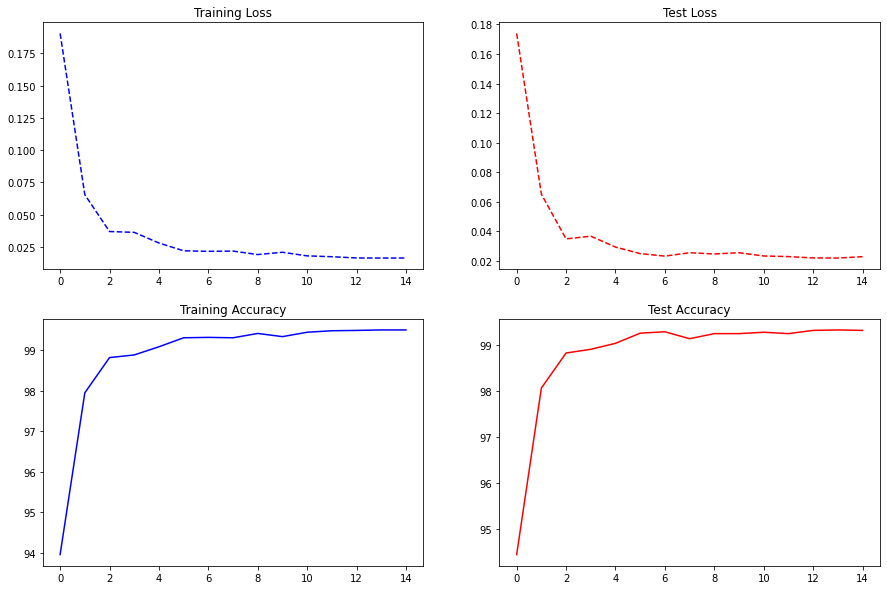

In [16]:
x_ticks = np.arange(0,epochs)
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(x_ticks,train_loss_vals, 'b--')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(x_ticks,train_acc_vals, 'b')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(x_ticks,test_loss_vals, 'r--')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(x_ticks,test_acc_vals, 'r')
axs[1, 1].set_title("Test Accuracy")
plt.savefig('../mnist_data/S3_mnist_plot.png')

## **[9] Results**

In [18]:
# num_row     = 4
# num_col     = 5
# num_images  = num_row*num_col

# random_batch  = np.random.randint(0, int(len(test_set)/batch_size_test))  # Select a random Batch
# random_images = np.random.randint(0, batch_size_test, size = num_images)  # Select a random sample of images in the batch

# model.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if batch_idx == random_batch:
#             images,labels = data[random_images].to(device), target[random_images].to(device)
#             output       = model(images)
#             pred         = output.argmax(dim=1, keepdim=True)
#             pred         = pred.view_as(labels)
#             break
# images,labels,pred  = images.cpu(),labels.cpu(),pred.cpu()

# # Plot the digit images with label and predictions
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.8*num_col,2.5*num_row))
# for i in range(num_images):
#     ax = axes[i//num_col, i%num_col]
#     ax.imshow(images[i][0], cmap='gray')
#     ax.set_title('Label: {}\nPrediction: {}'.format(labels[i],pred[i]))

# plt.tight_layout()
# plt.show()
# plt.savefig('../mnist_data/S3_prediction_vs_groundTruth.png')